<h1><center>Image Compression using Convolutional Autoencoders</center></h3>



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,Flatten,Reshape,Conv2DTranspose
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.datasets
import numpy as np
import cv2
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt

<h3>Loading the image</h3>

Shape of image (6081, 3856, 3)


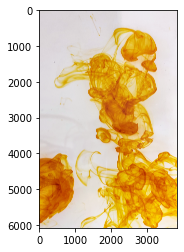

In [ ]:
file_path = 'check.png'
input_image = cv2.imread(file_path)
plt.imshow(input_image)
img_shape = input_image.shape
print("Shape of image",img_shape)

<h3>Approach</h3>

---

Dividing the image into multiple 32 x 32 x C shaped smaller images to form a dataset that is fed to the autoencoder. Since many images will have dimensions which will not be perfectly divisible by 32 x 32, therefore we pad zeros along the height and width of the image to get it into the right shape so we can get N x 32 x 32 x C shaped smaller images (where N is the number of such images produced and C is the color channel).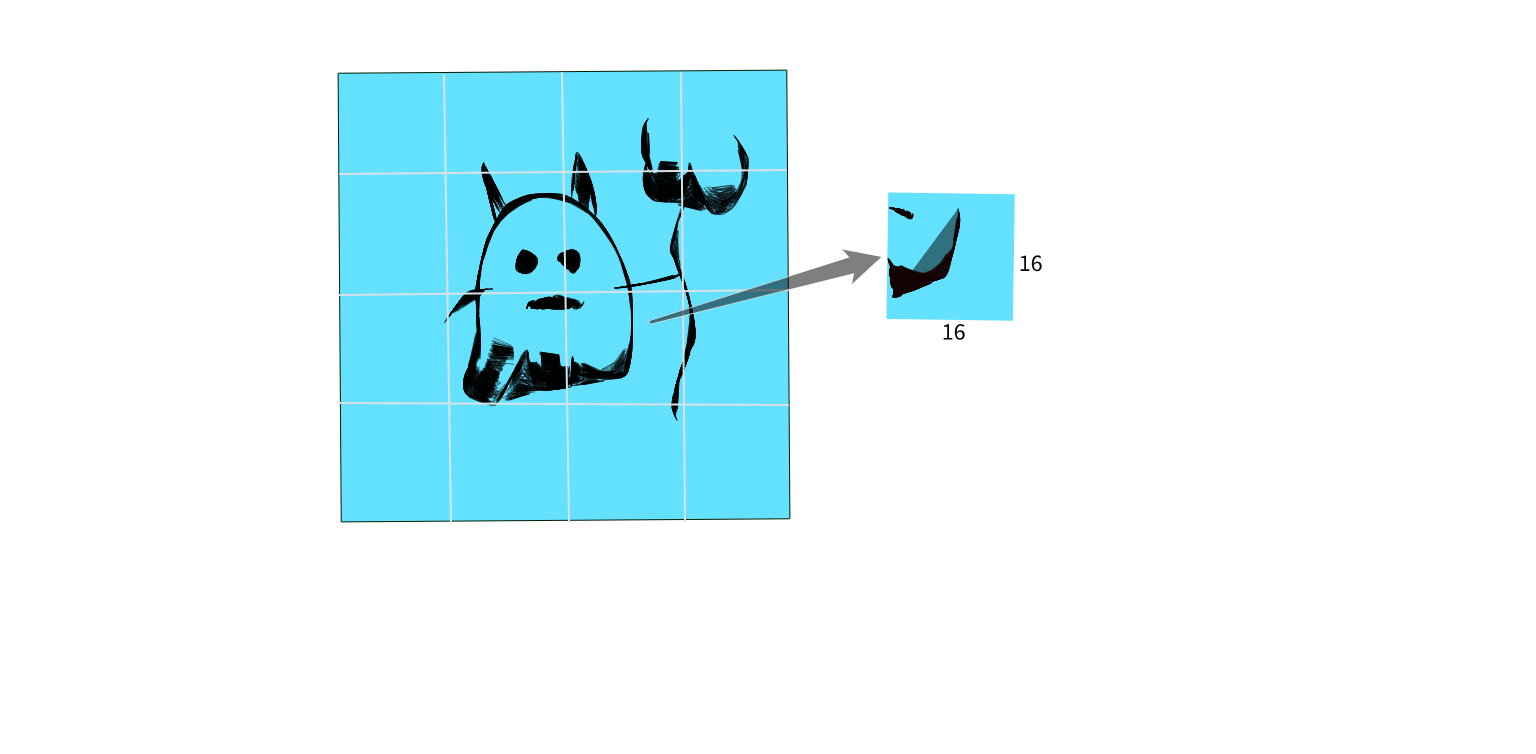

In [ ]:
def create_new_image(img,size):
  H,W,C = img.shape
  new_H = H if H % size == 0 else H + size - H % size
  new_W = H if W % size == 0 else W + size - W % size
  new_img = np.zeros((new_H,new_W,C),dtype=int)
  new_img[:H,:W,:] = img
  return new_img

In [ ]:
def create_data(img,size):
  H,W,C = img.shape
  d = (H // size) * (W // size)
  data = np.zeros((d,size,size,C))
  c = 0
  for i in range(H//size):
    for j in range(W//size):
      data[c,:,:,:] = img[i*size:(i+1)*size,j*size:(j+1)*size,:]
      c += 1
  return data

In [ ]:
def recreate_img(data,size,shape,original_shape):
  img = np.zeros(shape,dtype=int )
  H,W,C = shape
  c = 0
  for i in range(H//size):
    for j in range(W//size):
      img[i*size:(i+1)*size,j*size:(j+1)*size,:] = data[c,:,:,:]
      c += 1
  H,W,C = original_shape
  return img[:H,:W,:]

In [ ]:
original_shape = input_image.shape
block_size = 16
image = create_new_image(input_image,block_size)
shape = image.shape
x_train = create_data(image,block_size)

<h3>The Model</h3>

---

Autoencoders are neural network architecture concerned with learning a better representation of the inputs by discovering structure within the data. They are mainly useful for dimensionality reduction. It consists of the encoder and decoder which themselves can have different architectures irrespective of each other. We have used Convolutional Neural Networks for both the encoder and decoder simply because CNNs performs much better on image data when compared to a traditional FeedForward Neural Network. <br><br>
<h4>Encoder :-</h4> The encoder is a stack of convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (code_size).<br><br>
<h4>Decoder :-</h4>
The decoder of our network consists of the transpose convolution layers. Traditional convolutional layer takes a patch of an image and produces a number whereas in "transpose convolution" we want to take a number and produce a patch of an image. We need this layer to "undo" convolutions in encoder and produce the original image from the compressed encodings of the image.

In [ ]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder

    x = Input(shape=(img_shape))
    e1 = Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same')(x)
    mp1 = MaxPooling2D(pool_size=(2, 2))(e1)
    e2 = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same')(mp1)
    mp2 = MaxPooling2D(pool_size=(2, 2))(e2)
    e3 = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same')(mp2)
    mp3 = MaxPooling2D(pool_size=(2, 2))(e3)
    e4 = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same')(mp3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(e4)
    f = Flatten()(mp3)
    out_en = Dense(code_size)(f)
 
    encoder = tensorflow.keras.models.Model(x, out_en, name="encoder_model")

    # decoder
    x = Input(shape=(code_size,))
    d1 = Dense(2*2*256)(x)
    d1 = Reshape((2,2, 256))(d1)
    d2 = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same')(d1)
    d3 = Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same')(d2)
    out_de = Conv2DTranspose(filters=C, kernel_size=(3, 3), strides=2, activation='elu', padding='same')(d3)
    #out_de = Conv2DTranspose(filters=C, kernel_size=(3, 3), strides=2, activation=None, padding='same')(d4)

    decoder = tensorflow.keras.models.Model(x, out_de, name="decoder_model")

    ae_input = tensorflow.keras.layers.Input(shape=(img_shape))
    ae_encoder_output = encoder(ae_input)
    ae_decoder_output = decoder(ae_encoder_output)

    ae = tensorflow.keras.models.Model(ae_input, ae_decoder_output, name="AE")
    
    return encoder, decoder, ae

In [ ]:
# AE Compilation
encoder,decoder,ae = build_deep_autoencoder((block_size,block_size,original_shape[2]), 10)
ae.compile(loss="mse", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005))

In [ ]:
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 4, 4, 128)       

In [ ]:
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              11264     
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 4, 4, 64)         147520    
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 32)         18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 3)      

In [27]:
# Training AE
ae.fit(x_train, x_train, epochs=10, shuffle=True)

Epoch 1/10
4525/4525 [==============================] - 68s 8ms/step - loss: 222.6697
Epoch 2/10
4525/4525 [==============================] - 38s 8ms/step - loss: 16.1319
Epoch 3/10
4525/4525 [==============================] - 39s 9ms/step - loss: 11.3481
Epoch 4/10
4525/4525 [==============================] - 39s 9ms/step - loss: 10.0049
Epoch 5/10
4525/4525 [==============================] - 39s 9ms/step - loss: 9.3975
Epoch 6/10
4525/4525 [==============================] - 39s 9ms/step - loss: 9.3222
Epoch 7/10
4525/4525 [==============================] - 39s 9ms/step - loss: 8.9728
Epoch 8/10
4525/4525 [==============================] - 39s 9ms/step - loss: 8.5311
Epoch 9/10
4525/4525 [==============================] - 39s 9ms/step - loss: 8.4295
Epoch 10/10
4525/4525 [==============================] - 40s 9ms/step - loss: 8.2803


In [28]:
encoded_images = encoder.predict(x_train)
decoded_images = decoder.predict(encoded_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


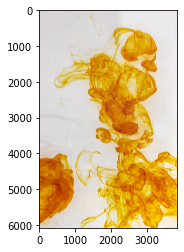

In [29]:
recreated_image = recreate_img(decoded_images,16,shape,original_shape)
plt.imshow(recreated_image)

In [30]:
def rmse(y_true, y_predict):
    return tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict))

In [31]:
print("Rmse:",rmse(input_image,recreated_image))

Rmse: tf.Tensor(13, shape=(), dtype=int64)


<h3>Saving the weights and encodings</h3>

In [32]:
decoder.save_weights("decoder.h5")
np.save('encoded_images.npy',encoded_images)

<h3>Loading the saved model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


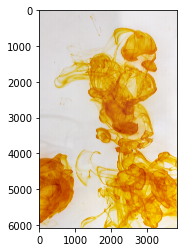

In [33]:
tf.keras.backend.clear_session()
encoded_images = np.load("encoded_images.npy")
decoder.load_weights("decoder.h5")
reconstruction = decoder(encoded_images)
reconstruction = recreate_img(reconstruction,16,shape,original_shape)
plt.imshow(reconstruction)